In [11]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from numpy import *

# Imports
import pandas as pd
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
import nltk.data
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
from gensim.models import word2vec


# initial imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

from scipy import stats
from scipy.stats import norm, skew #for some statistics

[nltk_data] Downloading package stopwords to /home/aman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/aman/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
y_train = train.age.values
data = pd.concat((train, test)).reset_index(drop=True)
data.drop(['age'], axis=1, inplace=True)

In [ ]:
data['year'] = data['date'].str[-4:]
data.head()

In [ ]:
def sentence_to_wordlist(review, remove_stopwords=False):
    review_text = BeautifulSoup(review).get_text()
    review_text = re.sub("[^a-zA-Z]", " ", review_text)
    words = review_text.lower().split()
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    return words

In [ ]:
# Word2Vec expects single sentences, 
# each one as a list of words. 
# In other words, the input format is a list of lists.
def review_to_sentences(review, tokenizer, remove_stopwords=False):
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(sentence_to_wordlist(raw_sentence, remove_stopwords))
    # Return the list of sentences (each sentence is a list of words,
    # so this returns a list of lists
    return sentences

In [ ]:
sentences = []  # Initialize an empty list of sentences
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
print ("Parsing sentences from data set")
for review in data["text"]:
    sentences += review_to_sentences(review, tokenizer, remove_stopwords=True)

In [ ]:
# Import the built-in logging module and configure it so that Word2Vec 
# creates nice output messages
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

# Set values for various parameters
num_features = 100    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 8       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
from gensim.models import word2vec
print ("Training model...")
model = word2vec.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

# It can be helpful to create a meaningful model name and 
# save the model for later use. You can load it later using Word2Vec.load()
model_name = "100features_40minwords_10context"
model.save(model_name)

In [ ]:
import numpy as np  # Make sure that numpy is imported

def makeFeatureVec(words, model, num_features):
    # Function to average all of the word vectors in a given
    # paragraph
    #
    # Pre-initialize an empty numpy array (for speed)
    featureVec = np.zeros((num_features,),dtype="float32")
    #
    nwords = 0
    # 
    # Index2word is a list that contains the names of the words in 
    # the model's vocabulary. Convert it to a set, for speed 
    index2word_set = set(model.index2word)
    #
    # Loop over each word in the review and, if it is in the model's
    # vocaublary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1
            featureVec = np.add(featureVec,model[word])
    # 
    # Divide the result by the number of words to get the average
    featureVec = np.divide(featureVec,nwords)
    return featureVec


def getAvgFeatureVecs(reviews, model, num_features):
    # Given a set of reviews (each one a list of words), calculate 
    # the average feature vector for each one and return a 2D numpy array 
    # 
    # Initialize a counter
    counter = int(0)
    # 
    # Preallocate a 2D numpy array, for speed
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    # 
    # Loop through the reviews
    for review in reviews:
       #
       # Print a status message every 1000th review
        if counter%10000. == 0.:
            print ("Review %d of %d" % (counter, len(reviews)))
       # 
       # Call the function (defined above) that makes average feature vectors
        reviewFeatureVecs[int(counter)] = makeFeatureVec(review, model, \
           num_features)
       #
       # Increment the counter
        counter = counter + 1
    return reviewFeatureVecs

In [ ]:
def review_to_wordlist( review, remove_stopwords=False ):
    # Function to convert a document to a sequence of words,
    # optionally removing stop words.  Returns a list of words.
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(review).get_text()
    #  
    # 2. Remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review_text)
    #
    # 3. Convert words to lower case and split them
    words = review_text.lower().split()
    #
    # 4. Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    #
    # 5. Return a list of words
    return(words)

In [ ]:
model = word2vec.Word2Vec.load("100features_40minwords_10context").wv
clean_train_reviews = []
for review in train["text"]:
    clean_train_reviews.append( review_to_wordlist( review, \
        remove_stopwords=True ))

In [ ]:
num_features = 100
trainDataVecs = getAvgFeatureVecs( clean_train_reviews, model, num_features )
import numpy
numpy.savetxt("data/trainDataVecs.csv", trainDataVecs, delimiter=",")
np.save('data/trainDataVecs.npy', trainDataVecs)

In [4]:
import gc
gc.collect()

7

In [ ]:
print ("Creating average feature vecs for test reviews")
clean_test_reviews = []
for review in test["text"]:
    clean_test_reviews.append( review_to_wordlist( review, \
        remove_stopwords=True ))

testDataVecs = getAvgFeatureVecs( clean_test_reviews, model, num_features )
numpy.savetxt("data/testDataVecs.csv", testDataVecs, delimiter=",")
np.save('data/testDataVecs.npy', testDataVecs)

In [9]:
# Initializing and fitting logistic regression model
from sklearn.linear_model import LinearRegression

from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC, LinearRegression
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [ ]:
lasso =  make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
cross_val_score(lasso, trainDataVecs, train['age'], cv=4)

In [ ]:
from numpy import *
where_are_NaNs = isnan(trainDataVecs)
trainDataVecs[where_are_NaNs] = 0
where_are_NaNs = isnan(testDataVecs)
testDataVecs[where_are_NaNs] = 0

In [ ]:
xgbm = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1)
cross_val_score(xgbm, trainDataVecs, train['age'], cv=4)

In [ ]:
xgbm.fit(trainDataVecs, train['age'])
preds = xgbm.predict(testDataVecs)
solution = pd.DataFrame({"user.id":test["user.id"], "age":preds})
solution = solution.groupby('user.id', as_index=False)['age'].mean()
solution.to_csv("solutions/word_vecs_xgbm.csv", index = False)

In [ ]:
lasso.fit(trainDataVecs, train['age'])
preds_lasso = lasso.predict(testDataVecs)
solution_lasso = pd.DataFrame({"user.id":test["user.id"], "age":preds_lasso})
solution_lasso = solution_lasso.groupby('user.id', as_index=False)['age'].mean()
solution_lasso.to_csv("solutions/word_vecs_sentiment_lasso.csv", index = False)

In [ ]:
preds_lasso.mean()

In [46]:
t = pd.read_csv('data/trainDataVecs.csv', header=None)

In [47]:
t2 = pd.read_csv('data/data_with_sentiment_score_and_one_hot.csv')

In [48]:
from sklearn import preprocessing
t2_n = t2[['length_text',
       'gender_female', 'gender_male', 'gender_nan', 'sign_Aquarius',
       'sign_Aries', 'sign_Cancer', 'sign_Capricorn', 'sign_Gemini',
       'sign_Leo', 'sign_Libra', 'sign_Pisces', 'sign_Sagittarius',
       'sign_Scorpio', 'sign_Taurus', 'sign_Virgo', 'sign_nan',
       'topic_Accounting', 'topic_Advertising', 'topic_Agriculture',
       'topic_Architecture', 'topic_Arts', 'topic_Automotive', 'topic_Banking',
       'topic_Biotech', 'topic_BusinessServices', 'topic_Chemicals',
       'topic_Communications-Media', 'topic_Construction', 'topic_Consulting',
       'topic_Education', 'topic_Engineering', 'topic_Environment',
       'topic_Fashion', 'topic_Government', 'topic_HumanResources',
       'topic_Internet', 'topic_InvestmentBanking', 'topic_Law',
       'topic_LawEnforcement-Security', 'topic_Manufacturing',
       'topic_Maritime', 'topic_Marketing', 'topic_Military',
       'topic_Museums-Libraries', 'topic_Non-Profit', 'topic_Publishing',
       'topic_RealEstate', 'topic_Religion', 'topic_Science',
       'topic_Sports-Recreation', 'topic_Student', 'topic_Technology',
       'topic_Telecommunications', 'topic_Tourism', 'topic_Transportation',
       'topic_indUnk', 'topic_nan', 'year_,,', 'year_1999', 'year_2000',
       'year_2001', 'year_2002', 'year_2003', 'year_2004', 'year_2005',
       'year_2006', 'year_nan']]

# Create x, where x the 'scores' column's values as floats
x = t2_n.values.astype(float)

# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# Create an object to transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(x)

# Run the normalizer on the dataframe
t2_n = pd.DataFrame(x_scaled)
t2_n.columns = ['length_text',
       'gender_female', 'gender_male', 'gender_nan', 'sign_Aquarius',
       'sign_Aries', 'sign_Cancer', 'sign_Capricorn', 'sign_Gemini',
       'sign_Leo', 'sign_Libra', 'sign_Pisces', 'sign_Sagittarius',
       'sign_Scorpio', 'sign_Taurus', 'sign_Virgo', 'sign_nan',
       'topic_Accounting', 'topic_Advertising', 'topic_Agriculture',
       'topic_Architecture', 'topic_Arts', 'topic_Automotive', 'topic_Banking',
       'topic_Biotech', 'topic_BusinessServices', 'topic_Chemicals',
       'topic_Communications-Media', 'topic_Construction', 'topic_Consulting',
       'topic_Education', 'topic_Engineering', 'topic_Environment',
       'topic_Fashion', 'topic_Government', 'topic_HumanResources',
       'topic_Internet', 'topic_InvestmentBanking', 'topic_Law',
       'topic_LawEnforcement-Security', 'topic_Manufacturing',
       'topic_Maritime', 'topic_Marketing', 'topic_Military',
       'topic_Museums-Libraries', 'topic_Non-Profit', 'topic_Publishing',
       'topic_RealEstate', 'topic_Religion', 'topic_Science',
       'topic_Sports-Recreation', 'topic_Student', 'topic_Technology',
       'topic_Telecommunications', 'topic_Tourism', 'topic_Transportation',
       'topic_indUnk', 'topic_nan', 'year_,,', 'year_1999', 'year_2000',
       'year_2001', 'year_2002', 'year_2003', 'year_2004', 'year_2005',
       'year_2006', 'year_nan']

In [49]:
final_data = pd.concat([t, t2_n, t2[['Positive', 'Negative', 'Neutral', 'Compound']]], axis=1)

In [50]:
train_columns = [0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
            68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
            85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99,
             'length_text', 'Positive', 'Negative', 'Neutral', 'Compound',
       'gender_female', 'gender_male', 'gender_nan', 'sign_Aquarius',
       'sign_Aries', 'sign_Cancer', 'sign_Capricorn', 'sign_Gemini',
       'sign_Leo', 'sign_Libra', 'sign_Pisces', 'sign_Sagittarius',
       'sign_Scorpio', 'sign_Taurus', 'sign_Virgo', 'sign_nan',
       'topic_Accounting', 'topic_Advertising', 'topic_Agriculture',
       'topic_Architecture', 'topic_Arts', 'topic_Automotive', 'topic_Banking',
       'topic_Biotech', 'topic_BusinessServices', 'topic_Chemicals',
       'topic_Communications-Media', 'topic_Construction', 'topic_Consulting',
       'topic_Education', 'topic_Engineering', 'topic_Environment',
       'topic_Fashion', 'topic_Government', 'topic_HumanResources',
       'topic_Internet', 'topic_InvestmentBanking', 'topic_Law',
       'topic_LawEnforcement-Security', 'topic_Manufacturing',
       'topic_Maritime', 'topic_Marketing', 'topic_Military',
       'topic_Museums-Libraries', 'topic_Non-Profit', 'topic_Publishing',
       'topic_RealEstate', 'topic_Religion', 'topic_Science',
       'topic_Sports-Recreation', 'topic_Student', 'topic_Technology',
       'topic_Telecommunications', 'topic_Tourism', 'topic_Transportation',
       'topic_indUnk', 'topic_nan', 'year_,,', 'year_1999', 'year_2000',
       'year_2001', 'year_2002', 'year_2003', 'year_2004', 'year_2005',
       'year_2006', 'year_nan']

train_data = final_data[train_columns][:len(train['text'])]
test_data = final_data[train_columns][len(train['text']):]

train_data = train_data.fillna(0)
test_data = test_data.fillna(0)


 mu = 23.54 and sigma = 7.60



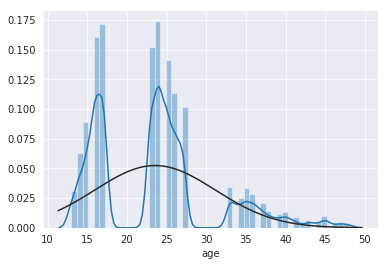

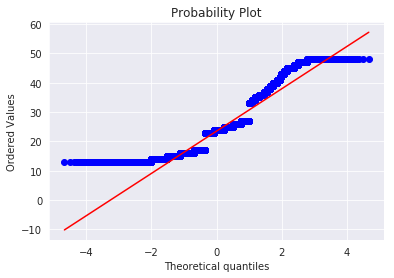

In [14]:
def is_skewed(col):
    sns.distplot(train[col] , fit=norm);
    fig = plt.figure()
    res = stats.probplot(train[col], plot=plt)
    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(train[col])
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
    
is_skewed('age')


 mu = 3.15 and sigma = 0.30



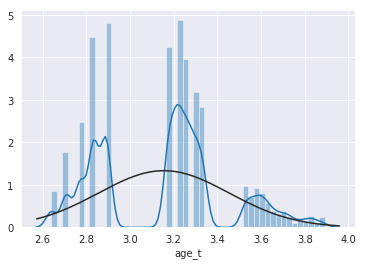

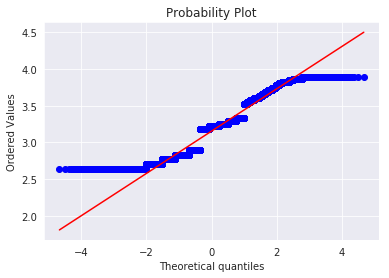

In [28]:
train["age_t"] = np.log1p(train["age"])
is_skewed('age_t')

In [51]:
lasso =  make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
cross_val_score(lasso, train_data, train['age_t'], cv=4)

array([0.36362029, 0.35147927, 0.34202493, 0.37544378])

In [12]:
xgbm = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1)
cross_val_score(xgbm, train_data, train['age'], cv=4)

array([0.34395293, 0.33350242, 0.32647197, 0.36623622])

In [20]:
import gc
gc.collect()

0

In [27]:
xgbm = xgb.XGBRegressor(n_estimators=360, max_depth=4, learning_rate=0.1)
cross_val_score(xgbm, train_data, train['age'], cv=4)

array([0.34740275, 0.34039158, 0.32054995, 0.36691908])

In [16]:
xgbm.fit(train_data, train['age'])
preds = xgbm.predict(test_data)
solution = pd.DataFrame({"user.id":test["user.id"], "age":preds})
solution = solution.groupby('user.id', as_index=False)['age'].mean()
solution.to_csv("solutions/word_vecs_metadata_xgbm.csv", index = False)

In [52]:
lasso.fit(train_data, train['age_t'])
preds_lasso = np.expm1(lasso.predict(test_data))
solution_lasso = pd.DataFrame({"user.id":test["user.id"], "age":preds_lasso})
solution_lasso = solution_lasso.groupby('user.id', as_index=False)['age'].mean()
solution_lasso.to_csv("solutions/word_vecs_metadata_lasso_normalization.csv", index = False)

In [ ]:
xgbm = xgb.XGBRegressor(n_estimators=360, max_depth=4, learning_rate=0.1)
cross_val_score(xgbm, train_data, train['age_t'], cv=4)

In [29]:
solution_lasso

,user.id,age
0,2,26.097750
1,8,23.512323
2,9,26.307722
3,10,24.116599
4,11,23.448533
5,13,20.072217
6,20,28.606135
7,26,20.307331
8,27,19.392220
9,29,25.077876
